In [111]:
import pyomo.environ as pyo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd

# search for "todo"

In [395]:
class hydro_opt:
    def __init__(self, input_data = None, h2_to_nh3_eff = None, h2_to_ch3oh_eff = None, h2_demand = None, nh3_demand = None, ch3oh_demand = None):
        # set default values for variables
        if input_data == None:
            #self.input_data = "Inputdata.xlsx"
            self.input_data = pd.read_excel("Inputdata.xlsx", index_col="Land", keep_default_na=False)
        else:
            self.input_data = input_data
        if h2_to_nh3_eff == None:
            self.h2_to_nh3_eff = 0.7
        else:
            self.h2_to_nh3_eff = h2_to_nh3_eff
        if h2_to_ch3oh_eff == None:
            self.h2_to_ch3oh_eff = 0.6
        else:
            self.h2_to_ch3oh_eff = h2_to_ch3oh_eff
        if h2_demand == None:
            self.h2_demand = 1000000
        else:
            self.h2_demand = h2_demand
        if nh3_demand == None:
            self.nh3_demand = 1000000
        else:
            self.nh3_demand = nh3_demand
        if ch3oh_demand == None:
            self.ch3oh_demand = 1000000
        else:
            self.ch3oh_demand = ch3oh_demand
        self.instance = None
        self.results_df = None
        
            
    def optimize(self, solve = "gurobi", show_model = False, return_model = False, return_as_df = False):
        """
        optimizes the given Model by minimizing the combined cost for:
            - import by ship and pipeline for H2, NH3 and CH3OH
            - conversion of H2 to NH3 or CH3OH 
        
        solve: string, default "gurobi"
            value for pyomo.environ.SolverFactory()
            defines the used Solver
        show_model: bool, default False
            if True: calls .display() on the optimized model to show the model in console
        return_model: bool, default False
            if True: returns the optimized pyomo model
        return_as_df: bool, default False
            if True: returns the optimized values as pandas DataFrame
            only used in combination with return_model=True
        """
        # set the optimization software to use
        solver = pyo.SolverFactory(solve) 
        # create the model and prepare to use the countries as Index
        model = pyo.ConcreteModel()
        model.country = self.input_data.index
        
        ### Params
        model.h2_price_production =  pyo.Param(model.country, initialize=self.input_data["H2 Herstellungspreis"].to_dict())
        model.h2_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["H2 Pipeline Preis"].to_dict())
        model.h2_price_ship =  pyo.Param(model.country, initialize=self.input_data["H2 Schiff Preis"].to_dict())
        model.h2_export_limit = pyo.Param(model.country, initialize=self.input_data["H2 Export Limit"].to_dict())

        model.nh3_price_production =  pyo.Param(model.country, initialize=self.input_data["NH3 Herstellungspreis"].to_dict())
        model.nh3_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["NH3 Pipeline Preis"].to_dict())
        model.nh3_price_ship =  pyo.Param(model.country, initialize=self.input_data["NH3 Schiff Preis"].to_dict())
        model.nh3_export_limit = pyo.Param(model.country, initialize=self.input_data["NH3 Export Limit"].to_dict())

        model.ch3oh_price_production =  pyo.Param(model.country, initialize=self.input_data["CH3OH Herstellungspreis"].to_dict())
        model.ch3oh_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["CH3OH Pipeline Preis"].to_dict())
        model.ch3oh_price_ship =  pyo.Param(model.country, initialize=self.input_data["CH3OH Schiff Preis"].to_dict())
        model.ch3oh_export_limit = pyo.Param(model.country, initialize=self.input_data["CH3OH Export Limit"].to_dict())
        
        ### Variables
        model.h2_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

        model.nh3_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.nh3_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

        model.ch3oh_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.ch3oh_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        
        model.h2_amount_to_nh3_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_to_nh3_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_to_ch3oh_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_to_ch3oh_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        
        ### objective function
        obj_expr = sum(
                # transport costs * quantity per transport option + production price * delivered amount
                  model.h2_price_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_price_ship[i]*model.h2_amount_ship[i] + model.h2_price_production[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i])
                + model.nh3_price_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_price_ship[i]*model.nh3_amount_ship[i] + model.nh3_price_production[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i])                         
                + model.ch3oh_price_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_price_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price_production[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i])
                # hydrogen which will be converted into chemicals
                + model.h2_amount_to_nh3_pipeline[i]*(model.h2_price_pipeline[i]+model.h2_price_production[i]) + model.h2_amount_to_nh3_ship[i]*(model.h2_price_ship[i]+model.h2_price_production[i])
                + model.h2_amount_to_ch3oh_pipeline[i]*(model.h2_price_pipeline[i]+model.h2_price_production[i]) + model.h2_amount_to_ch3oh_ship[i]*(model.h2_price_ship[i]+model.h2_price_production[i])
                for i in model.country) 
        model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)
        
        ### constraints
        # demand
        model.demand_constraints = pyo.ConstraintList()
        # hydrogen demand needs to be satisfied
        con_demand_h2_lhs = sum(model.h2_amount_pipeline[i] + model.h2_amount_ship[i] for i in model.country)  
        con_demand_h2_rhs = self.h2_demand
        model.demand_constraints.add(con_demand_h2_lhs >= con_demand_h2_rhs)
        # ammonia demand needs to be satisfied by imported ammonia and hydrogen converted to ammonia
        con_demand_nh3_lhs = sum(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]
                                 + self.h2_to_nh3_eff*(model.h2_amount_to_nh3_pipeline[i] + model.h2_amount_to_nh3_ship[i])
                                 for i in model.country)
        con_demand_nh3_rhs = self.nh3_demand
        model.demand_constraints.add(con_demand_nh3_lhs >= con_demand_nh3_rhs)
        # methanol demand needs to be satisfied by imported methanol and hydrogen converted to methanol
        con_demand_ch3oh_lhs = sum(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]
                                   + self.h2_to_ch3oh_eff*(model.h2_amount_to_ch3oh_pipeline[i] + model.h2_amount_to_ch3oh_ship[i])
                                   for i in model.country)
        con_demand_ch3oh_rhs = self.ch3oh_demand
        model.demand_constraints.add(con_demand_ch3oh_lhs >= con_demand_ch3oh_rhs)

        # export limits
        model.export_constraints = pyo.ConstraintList()

        for i in model.country:
            # hydrogen demand + hydrogen for conversion can't exceed export limit of country i
            con_export_h2_lhs = (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]
                                 + model.h2_amount_to_nh3_pipeline[i] + model.h2_amount_to_nh3_ship[i]
                                 + model.h2_amount_to_ch3oh_pipeline[i] + model.h2_amount_to_ch3oh_ship[i])
            con_export_h2_rhs = model.h2_export_limit[i]
            model.export_constraints.add(con_export_h2_lhs <= con_export_h2_rhs)
            model.export_constraints.add(0 <= con_export_h2_lhs)

            con_export_nh3_lhs = model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]
            con_export_nh3_rhs = model.nh3_export_limit[i]
            model.export_constraints.add(con_export_nh3_lhs <= con_export_nh3_rhs)
            model.export_constraints.add(0 <= con_export_nh3_lhs)

            con_export_ch3oh_lhs = model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]
            con_export_ch3oh_rhs = model.ch3oh_export_limit[i]
            model.export_constraints.add(con_export_ch3oh_lhs <= con_export_h2_rhs)
            model.export_constraints.add(0 <= con_export_ch3oh_lhs)
            
        ### exchange
        #model.exchange_contraints = pyo.ContraintList()
        #for i in model.country:
        #    con_exchange_nh3_lhs = model.h2_amount_pipeline[i] + model.h2_amount_ship[i]
        #    con_exchange_nh3_rhs = model.h2_amount_to_nh3[i]
        #    model.exchange_constraints.add(con_exchange_nh3_lhs >=
            
        
        ### solve
        self.instance = model.create_instance()

        solver.options['NonConvex'] = 2
        results = solver.solve(self.instance)
        #print(results)
        
        self.results_df = pd.DataFrame(index = self.instance.country)
                
        opt_h2_amount_ship = {x:self.instance.h2_amount_ship[x].value for x in self.instance.country}
        opt_h2_amount_pipeline = {x:self.instance.h2_amount_pipeline[x].value for x in self.instance.country}
        opt_nh3_amount_ship = {x:self.instance.nh3_amount_ship[x].value for x in self.instance.country}
        opt_nh3_amount_pipeline = {x:self.instance.nh3_amount_pipeline[x].value for x in self.instance.country}
        opt_ch3oh_amount_ship = {x:self.instance.ch3oh_amount_ship[x].value for x in self.instance.country}
        opt_ch3oh_amount_pipeline = {x:self.instance.ch3oh_amount_pipeline[x].value for x in self.instance.country}
        opt_h2_amount_to_nh3_ship = {x:self.instance.h2_amount_to_nh3_ship[x].value for x in self.instance.country}
        opt_h2_amount_to_nh3_pipeline = {x:self.instance.h2_amount_to_nh3_pipeline[x].value for x in self.instance.country}
        opt_h2_amount_to_ch3oh_ship = {x:self.instance.h2_amount_to_ch3oh_ship[x].value for x in self.instance.country}
        opt_h2_amount_to_ch3oh_pipeline = {x:self.instance.h2_amount_to_ch3oh_pipeline[x].value for x in self.instance.country}
                
        self.results_df["H2 Schiff"] = opt_h2_amount_ship
        self.results_df["H2 Pipeline"] = opt_h2_amount_pipeline
        self.results_df["H2 zu NH3 Schiff"] = opt_h2_amount_to_nh3_ship
        self.results_df["H2 zu NH3 Pipeline"] = opt_h2_amount_to_nh3_pipeline
        self.results_df["H2 für NH3 Umwandlung"] = self.results_df["H2 zu NH3 Schiff"] + self.results_df["H2 zu NH3 Pipeline"]
        self.results_df["H2 zu CH3OH Schiff"] = opt_h2_amount_to_ch3oh_ship
        self.results_df["H2 zu CH3OH Pipeline"] = opt_h2_amount_to_ch3oh_pipeline
        self.results_df["H2 für CH3OH Umwandlung"] = self.results_df["H2 zu CH3OH Schiff"] + self.results_df["H2 zu CH3OH Pipeline"]
        self.results_df["H2 für Umwandlung"] = self.results_df["H2 für NH3 Umwandlung"] + self.results_df["H2 für CH3OH Umwandlung"]
        self.results_df["H2 Import"] = self.results_df["H2 Pipeline"] + self.results_df["H2 Schiff"] + self.results_df["H2 für Umwandlung"]
        self.results_df["NH3 Schiff"] = opt_nh3_amount_ship
        self.results_df["NH3 Pipeline"] = opt_nh3_amount_pipeline
        self.results_df["NH3 Import"] = self.results_df["NH3 Pipeline"] + self.results_df["NH3 Schiff"]
        self.results_df["CH3OH Schiff"] = opt_ch3oh_amount_ship
        self.results_df["CH3OH Pipeline"] = opt_ch3oh_amount_pipeline
        self.results_df["CH3OH Import"] = self.results_df["CH3OH Pipeline"] + self.results_df["CH3OH Schiff"]
        self.results_df["Gesamter Import"] = self.results_df["H2 Import"] + self.results_df["NH3 Import"] + self.results_df["CH3OH Import"]
        
        if show_model:
            self.instance.display()
            
        if return_model:
            if return_as_df:                
                return self.results_df
            else:
                return self.instance
        
        
    def visualize(self, what="combined import", vis_style="map", cmap="viridis", figsize=(16,9), return_df = False):
        """
        Allows for visualisations of the results from the optimization. If different visualisations are needed, get the model results by calling ".optimize(return_model=True)"
        
        keywords:
            description
        """
        if self.instance == None:
            print("Es ist kein optimiertes Model vorhanden. Für die Visualisierung muss zuerst die Methode \".optimize()\" ausgeführt werden")
            return
        # map needs aditional geometry
        if vis_style == "map":
            world = gpd.read_file("ne_110m_admin_0_countries.zip", include_fields=["ISO_A2_EH", "geometry"])
            vis_df = world.merge(self.results_df, how = "left", left_on="ISO_A2_EH", right_index=True).set_index("ISO_A2_EH")
        else:
            vis_df = self.results_df
            
        if what == "combined_import":
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            ax.set_title("Import von grünem Wasserstoff und wasserstoffbasierten Chemikalien nach Exportland")
            
            if vis_style=="map":
                vis_df.plot(column='Gesamter Import', cmap=cmap, ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, legend_kwds={'shrink': 0.7})
                ax.set_xticks([])
                ax.set_yticks([])
            elif vis_style =="bar":
                # only show values > 0 for visivility / ease of interpretation
                positive_values = vis_df[vis_df["Gesamter Import"] > 0].sort_values(by="Gesamter Import",ascending=False)
                plt.bar(positive_values.index, positive_values['Gesamter Import'])
                for index, value in zip(positive_values.index, positive_values['Gesamter Import']):
                    plt.text(index, value + 0.1, str(int(value)), ha='center', va='bottom')
                # TODO unit
                ax.set_ylabel("MWh")
                ax.set_xlabel("Exportland")
            
                        
        elif what == "commodities":
            fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True)
            fig.suptitle("Import von grünem Wasserstoff und wasserstoffbasierten Chemikalien nach Exportland und Chemikalie")
            ax[0].set_title("H2")
            ax[1].set_title("NH3")
            ax[2].set_title("CH3OH")

            
            max_value = max(vis_df["H2 Import"].max(), vis_df["NH3 Import"].max(), vis_df["CH3OH Import"].max())

            if vis_style == "map":                
                vis_df.plot(column='H2 Import', cmap=cmap, vmax=max_value, ax=ax[0], missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='NH3 Import', cmap=cmap, vmax=max_value, ax=ax[1], missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='CH3OH Import', cmap=cmap, vmax=max_value, ax=ax[2], missing_kwds={'color': 'lightgrey'})
                
                # Turn off tick labels
                for x in ax:
                    x.set_xticks([])
                    x.set_yticks([])
                
                # define a mappable based on which the colorbar will be drawn
                mappable = cm.ScalarMappable(
                    norm=mcolors.Normalize(0, max_value),
                    cmap=cmap
                )

                # draw colorbar
                cbar = fig.colorbar(mappable, ax=ax[:], shrink=0.9)

                
            elif vis_style == "bar":
                 # only show values > 0 for visivility / ease of interpretation
                positive_values = vis_df[vis_df["Gesamter Import"] > 0].sort_values(by="Gesamter Import", ascending=False)
                for axid, commodity in enumerate(["H2 Import", "NH3 Import", "CH3OH Import"]):
                    ax[axid].bar(positive_values.index, positive_values[commodity])
                    for index, value in zip(positive_values.index, positive_values[commodity]):
                        ax[axid].text(index, value + 0.1, str(int(value)), ha='center', va='bottom')
                    # TODO unit
                    ax[axid].set_ylabel("MWh")
                    ax[axid].set_xlabel("Exportland")
                    ax[axid].set_ylim(bottom=0,top=max_value*1.1)
                plt.tight_layout()
                
                
        elif what == "hydrogen_conversion":
            fig = plt.figure(figsize=figsize)
            fig.suptitle("Detailansicht der Herkunft des grünen Wasserstoffes nach Exportland und Transportmedium")
            
            # first row
            ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4)
            ax1.set_title('H2 Import') 
            
            # second row
            ax2 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
            ax2.set_title('H2 Import per Schiff')
            
            ax3 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
            ax3.set_title('H2 Import per Pipeline')
            
            # third row 
            ax4 = plt.subplot2grid((4, 4), (2, 0))
            ax4.set_title('für Verbrauch per Schiff')

            ax5 = plt.subplot2grid((4, 4), (2, 1))
            ax5.set_title('zur Umwandlung per Schiff')

            ax6 = plt.subplot2grid((4, 4), (2, 2))
            ax6.set_title('für Verbrauch per Pipeline')

            ax7 = plt.subplot2grid((4, 4), (2, 3))
            ax7.set_title('zur Umwandlung per Pipeline')
            
            # fouth row
            ax8 = plt.subplot2grid((4, 4), (3, 0))
            ax8.set_title('zur Umwandlung in NH3 per Schiff')
            
            ax9 = plt.subplot2grid((4, 4), (3, 1))
            ax9.set_title('zur Umwandlung in CH3OH per Schiff')
            
            ax10 = plt.subplot2grid((4, 4), (3, 2))
            ax10.set_title('zur Umwandlung in NH3 per Pipeline')
            
            ax11 = plt.subplot2grid((4, 4), (3, 3))
            ax11.set_title('zur Umwandlung in CH3OH per Pipeline')
            
            vis_df["H2 Gesamt Schiff"] = vis_df["H2 Schiff"] + vis_df["H2 zu NH3 Schiff"] + vis_df["H2 zu CH3OH Schiff"]
            vis_df["H2 Gesamt Pipeline"] = vis_df["H2 Pipeline"] + vis_df["H2 zu NH3 Pipeline"] + vis_df["H2 zu CH3OH Pipeline"]
            vis_df["H2 für Umwandlung Schiff"] = vis_df["H2 zu NH3 Schiff"] + vis_df["H2 zu CH3OH Schiff"]
            vis_df["H2 für Umwandlung Pipeline"] = vis_df["H2 zu NH3 Schiff"] + vis_df["H2 zu CH3OH Schiff"]

            if vis_style == "map":
                vis_df.plot(column='H2 Import', cmap=cmap, ax=ax1, missing_kwds={'color': 'lightgrey'})
                
                vis_df.plot(column='H2 Gesamt Schiff', cmap=cmap, ax=ax2, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 Gesamt Pipeline', cmap=cmap, ax=ax3, missing_kwds={'color': 'lightgrey'})
                
                vis_df.plot(column='H2 Schiff', cmap=cmap, ax=ax4, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 für Umwandlung Schiff', cmap=cmap, ax=ax5, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 Pipeline', cmap=cmap, ax=ax6, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 für Umwandlung Pipeline', cmap=cmap, ax=ax7, missing_kwds={'color': 'lightgrey'})
                
                vis_df.plot(column='H2 zu NH3 Schiff', cmap=cmap, ax=ax8, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 zu CH3OH Schiff', cmap=cmap, ax=ax9, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 zu NH3 Pipeline', cmap=cmap, ax=ax10, missing_kwds={'color': 'lightgrey'})
                vis_df.plot(column='H2 zu CH3OH Pipeline', cmap=cmap, ax=ax11, missing_kwds={'color': 'lightgrey'})
                
                # Turn off tick labels
                for axs in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]:
                    axs.set_xticks([])
                    axs.set_yticks([])
            
            elif vis_style == "bar":
                # only show values > 0 for visivility / ease of interpretation
                positive_values = vis_df[vis_df["H2 Import"] > 0].sort_values(by="H2 Import", ascending=False)
                for key, axid  in {"H2 Import": ax1,
                                   'H2 Gesamt Schiff': ax2, 'H2 Gesamt Pipeline': ax3,
                                   "H2 Schiff": ax4, "H2 für Umwandlung Schiff": ax5, "H2 Pipeline": ax6, "H2 für Umwandlung Pipeline": ax7, 
                                   "H2 zu NH3 Schiff": ax8, "H2 zu CH3OH Schiff": ax9, "H2 zu NH3 Pipeline": ax10, "H2 zu CH3OH Pipeline": ax11
                                   }.items():
                    axid.bar(positive_values.index, positive_values[key])
                    # on show values on bars in biggest graph
                    if key == "H2 Import":
                        for index, value in zip(positive_values.index, positive_values[key]):
                            axid.text(index, value + 0.1, str(int(value)), ha='center', va='bottom')
                    # TODO unit
                    axid.set_ylabel("MWh")
                    axid.set_xlabel("Exportland")
                    max_value = max(positive_values[key].max(),2)
                    axid.set_ylim(bottom=0, top=max_value*1.2)
                #plt.tight_layout()
                
            
            
        # catches
        else:
            print("keine passende Visusalisierung (what= ) ausgewählt")
            plt.close()
    
        if vis_style not in ["map", "bar"]:
            print("kein passender vis_style ausgewählt")
            plt.close()
        
        if return_df:
            return vis_df

        
        

In [396]:
t1=hydro_opt()

In [397]:
t1.optimize()

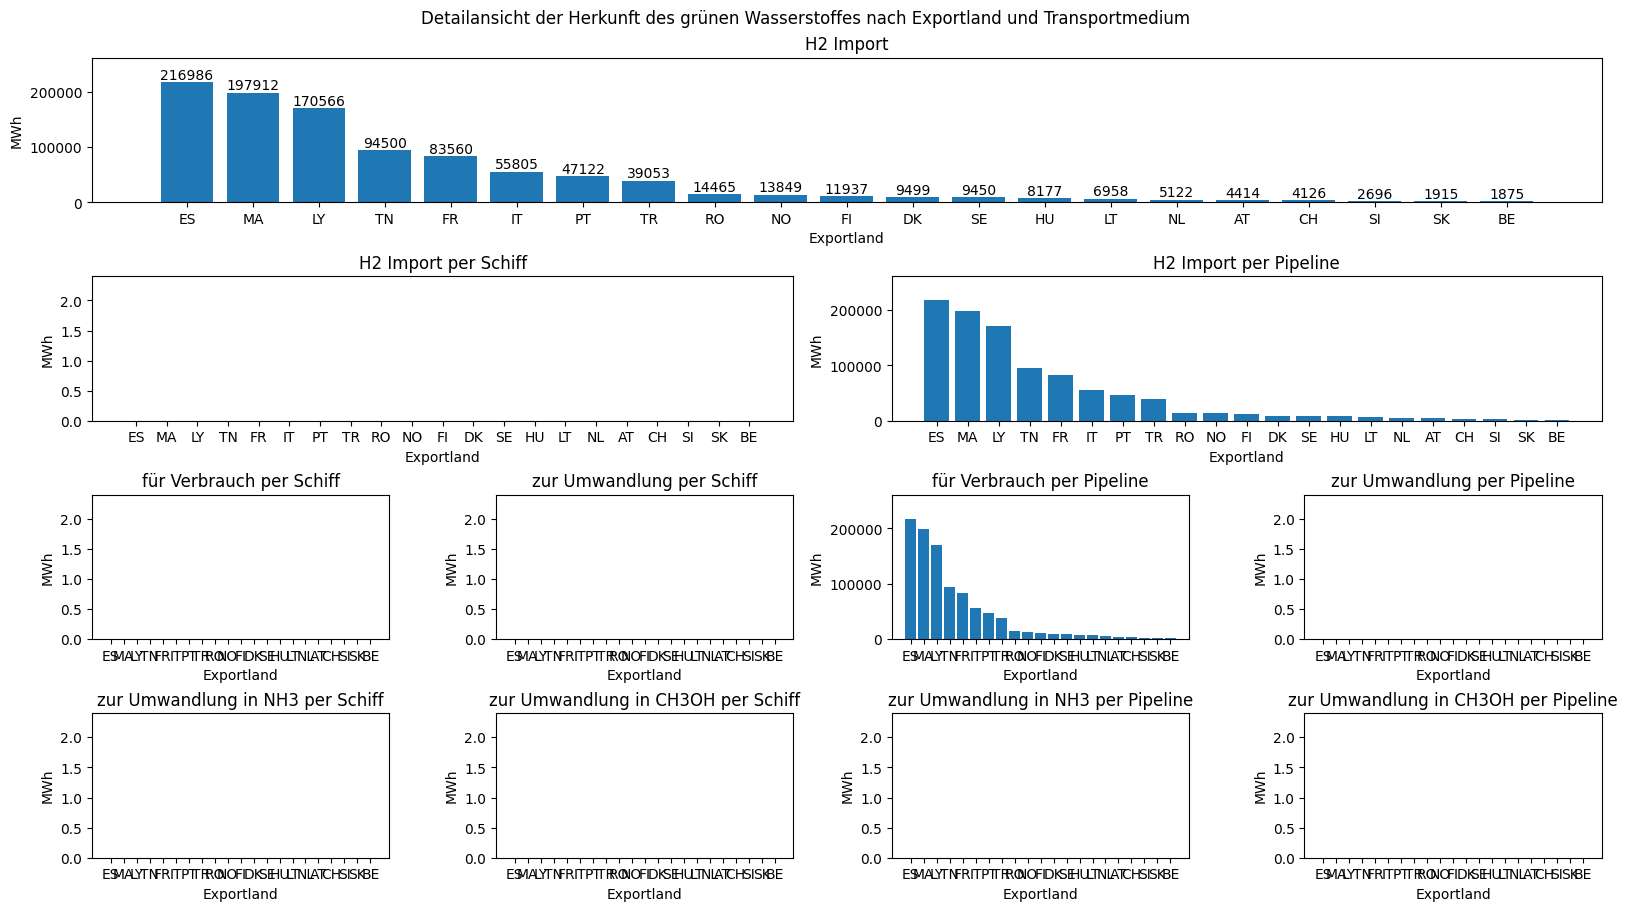

In [398]:
t11 = t1.visualize(what= "hydrogen_conversion", vis_style = "bar", return_df=True, figsize=(16,9))

In [399]:
t2 = hydro_opt(h2_to_nh3_eff=10, h2_to_ch3oh_eff=5)

In [400]:
t2.optimize()

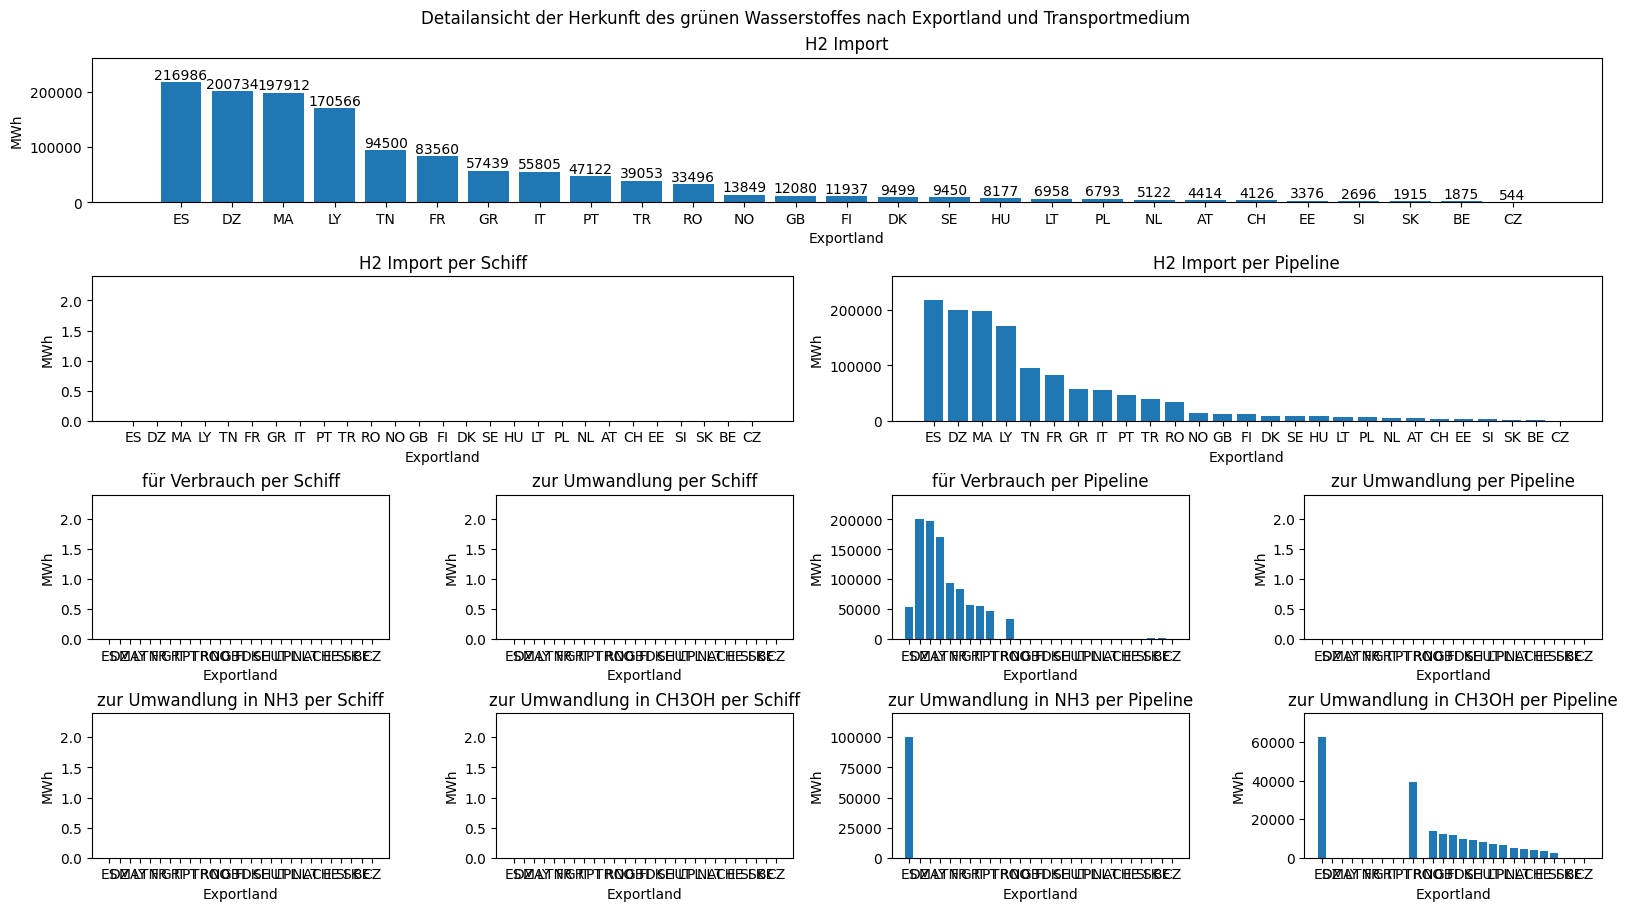

In [401]:
t21 = t2.visualize(what= "hydrogen_conversion", vis_style = "bar", return_df=True, figsize=(16,9))